<a href="https://colab.research.google.com/github/shiva-lashkari/yelp_rating_factors/blob/master/Yelp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 74.6 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 596 kB 67.1 MB/s 
     |████████████████████████████████| 56 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import glue_convert_examples_to_features
from transformers import AdamW
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/DeepLearning
!ls

/content/drive/MyDrive/DeepLearning
Assignment2  dataset  __MACOSX


In [6]:
# import zipfile
# import os

# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/DeepLearning/dataset.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/content/drive/MyDrive/DeepLearning') #Extracts the files into the /tmp folder
# zip_ref.close()

In [6]:
business_data = pd.read_csv('/content/drive/MyDrive/DeepLearning/dataset/yelp_business.csv')

In [7]:
business_data = business_data[business_data['categories'].str.contains("Restaurants")]
business_data.rename(columns={'stars': 'business_stars', 'name': 'business_name'}, inplace=True)
business_data.head()

,business_id,business_name,neighborhood,address,city,state,postal_code,latitude,longitude,business_stars,review_count,is_open,categories
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
5,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,1,Italian;Restaurants
10,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",NaN,"""737 West Pike St""",Houston,PA,15342,40.241548,-80.212815,4.5,3,0,Breakfast & Brunch;Gluten-Free;Coffee & Tea;Fo...
14,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Uptown,"""600 E 4th St""",Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,Restaurants;American (Traditional)
15,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",Yonge and Eglinton,"""2459 Yonge St""",Toronto,ON,M4P 2H6,43.711399,-79.399339,3.0,12,0,Italian;French;Restaurants


In [8]:
review_data = pd.read_csv('/content/drive/MyDrive/DeepLearning/dataset/yelp_review.csv')
review_data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [9]:
user_data = pd.read_csv('/content/drive/MyDrive/DeepLearning/dataset/yelp_user.csv')

In [10]:
review_merged = review_data.merge(business_data, how='inner', on='business_id')

In [11]:
review_merged.drop(["business_id","postal_code","address","latitude","longitude","review_count","is_open"],
                   axis=1, inplace=True)

In [12]:
review_merged = review_merged.merge(user_data, how='inner', on='user_id')

In [13]:
review_merged.drop(["user_id","name","friends","fans","elite","compliment_hot","compliment_more",
                    "compliment_profile", "compliment_cute", "compliment_list", "compliment_note", 
                    "compliment_plain", "compliment_cool", "compliment_funny", "compliment_writer", 
                    "compliment_photos"], axis=1, inplace=True)

In [14]:
review_merged.head()

,review_id,stars,date,text,useful_x,funny_x,cool_x,business_name,neighborhood,city,state,business_stars,categories,review_count,yelping_since,useful_y,funny_y,cool_y,average_stars
0,vkVSCC7xljjrAI4UGfnKEQ,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,"""Wilensky's""",Plateau-Mont-Royal,Montréal,QC,4.0,Diners;Food;Restaurants;Delis,6,2015-12-22,0,0,0,4.67
1,n6QzIUObkYshz4dz2QRJTw,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,"""Tuck Shop""",Sud-Ouest,Montréal,QC,4.5,Restaurants;Canadian (New);Italian,6,2015-12-22,0,0,0,4.67
2,MV3CcKScW05u5LVfF6ok0g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,"""Lester's Deli""",Outremont,Outremont,QC,4.0,Specialty Food;Food;Sandwiches;Restaurants;Bur...,6,2015-12-22,0,0,0,4.67
3,IXvOzsEMYtiJI0CARmj77Q,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,"""Five Guys""",Ville-Marie,Montréal,QC,3.5,Fast Food;Restaurants;Burgers,6,2015-12-22,0,0,0,4.67
4,L_9BTb55X0GDtThi6GlZ6w,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,"""Maison Christian Faure""",Ville-Marie,Montréal,QC,4.5,Bakeries;Restaurants;Food;Sandwiches;Cafes;Cof...,6,2015-12-22,0,0,0,4.67


In [15]:
review_merged.to_csv('/content/drive/MyDrive/DeepLearning/dataset/yelp_dataset.csv')

In [17]:
#Pre-Processing

In [18]:
# re_tokenizer = RegexpTokenizer("[\\w']+")
# review_merged['text_cleaned'] = review_merged['text'].apply(re_tokenizer.tokenize)

In [19]:
# # Clean up
# punc = string.punctuation
# stopwords_nltk = nltk.corpus.stopwords.words('english')
# # Custom stop words based on Frequency (Next cell or meanless one)
# # stopwords_nltk.extend([]) 

# digits = string.digits 

# review_merged['text_cleaned'] = review_merged['text_cleaned'].apply(lambda x: [word.lower() for word in x])
# review_merged['text_cleaned'] = review_merged['text_cleaned'].apply(lambda x: [word for word in x if word not in digits]) 
# review_merged['text_cleaned'] = review_merged['text_cleaned'].apply(lambda x: [word for word in x if word not in punc])
# review_merged['text_cleaned'] = review_merged['text_cleaned'].apply(lambda x: [word for word in x if word not in stopwords_nltk])
# review_merged['text_cleaned'] = review_merged['text_cleaned'].apply(lambda x: [word for word in x if len(word)>3]) # Drops single-letter tokens

In [16]:
review_df = review_merged[['text','stars']]
review_df

,text,stars
0,Super simple place but amazing nonetheless. It...,5
1,Small unassuming place that changes their menu...,5
2,Lester's is located in a beautiful neighborhoo...,5
3,Love coming here. Yes the place always needs t...,4
4,Had their chocolate almond croissant and it wa...,4
...,...,...
3221408,Tried the pizza it's delicious probably the be...,5
3221409,"Lydia and her team were so wonderful, we loved...",5
3221410,Johnnie's Java is the best Coffee Catering com...,5
3221411,Mr Martz isnt very smart by publicly admitting...,1


In [17]:
def generate_dataset(df, nrows=150000):
    for rating in range(1, 6, 1):
        df_rating = df[df['stars'] == rating]
        if len(df_rating) > nrows//5:
            df_rating = df_rating.iloc[:nrows//5, :]
            df = df.loc[~(df['stars'] == rating), :]
            df = df.append(df_rating)
        if len(df) == nrows:
            return df

In [18]:
train_df = generate_dataset(review_df)
test_df = generate_dataset(review_df)

In [19]:
train_df['stars'].value_counts()

5    30000
4    30000
3    30000
2    30000
1    30000
Name: stars, dtype: int64

In [20]:
test_df['stars'].value_counts()

5    30000
4    30000
3    30000
2    30000
1    30000
Name: stars, dtype: int64

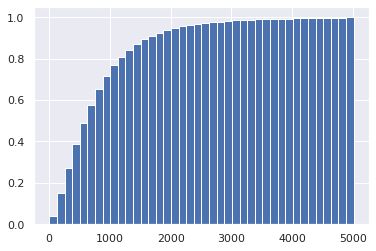

In [21]:
kwargs = {'cumulative': True}
plt.hist(train_df['text'].str.len().tolist() + test_df['text'].str.len().tolist(),cumulative=True, density=True, bins=40)
plt.show()

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
hidden_size = 200
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Total model trainable parameters 108465077
Total head trainable parameters 154805


In [24]:
model.classifier

Linear(
  in_features=768, out_features=200, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=200, out_features=5, bias=True)
)

In [25]:
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [26]:
train_dataset = get_features(train_df, 'text', 'stars')

  0%|          | 0/150000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [27]:
test_dataset = get_features(test_df, 'text', 'stars')

  0%|          | 0/150000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [28]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [29]:
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

In [30]:
batch_size = 16
gradient_every = 32
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 10

lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

In [31]:
tr_losses = []
v_losses = []

In [32]:
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}
        
        output = model(**feed_dict)
        loss = output['loss']

        # gradient accumulation
        epoch_tr_losses.append(output['loss'].item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()} 

            output_v = model(**feed_dict)
            loss = output_v['loss']
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')
    torch.save(model.classifier.state_dict(), f'/content/drive/MyDrive/DeepLearning/Assignment2/yelp-head{epoch}.pt')

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.411953328365849


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.3420959868664935
epoch 2


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.333657941417859


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.333228181165927
epoch 3


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.3135283077729485


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2855822390584803
epoch 4


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.2964139403283073


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.3036597090235142
epoch 5


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.2875174642682894


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2838667579042886
epoch 6


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.279507413587742


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.295607275037623
epoch 7


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.2757910932938503


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2769168461563745
epoch 8


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.26525549359247


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2942889139596334
epoch 9


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.267017866274451


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2511955755097526
epoch 10


batch:   0%|          | 0/8438 [00:00<?, ?it/s]

train NLL loss: 1.2632186117825506


val batch:   0%|          | 0/469 [00:00<?, ?it/s]

validation BCE loss: 1.2785927640603805


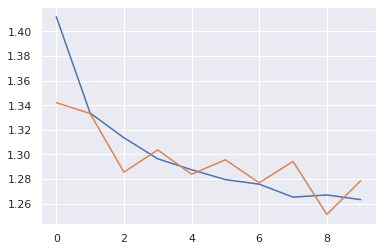

In [33]:
plt.plot(tr_losses)
plt.plot(v_losses)

In [34]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/4688 [00:00<?, ?it/s]

In [35]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

In [36]:
from sklearn.metrics import f1_score
f1_score(actual, predictions, average='micro')

0.43028

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

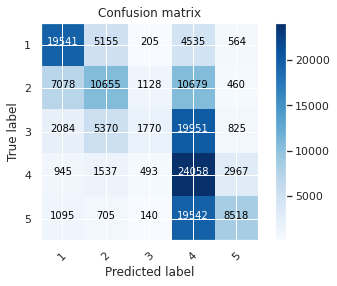

In [38]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()